# How can we reduce the error in Zillow's Zestimate?

### Paddy Doran and Sean Oslin
November 12, 2019

# Project planning

### Project goals

1. Determine what factor(s) is driving the difference in Zestimate to sales price (i.e 'logerror').

2. Build an improved model to predict the logerror.

### Deliverables

1. Verbal presentation of findings
2. MySQL notebook with database queries that were imported into Python for analysis
3. README with data definitions and analysis notes
4. Data analysis in a Jupyter Notebook that will allow for replication of analysis
5. Github repository holding the analysis and supporting materials

## Data acquisition

### Data source
All data originated with the Zillow database.

### Python libraries used

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import anderson
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from statsmodels.graphics.gofplots import qqplot
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


### Python programming for this analysis imported from associated text documents¶

In [2]:
import env
df = pd.read_csv("zillow.csv")

## Data preparation

#### Force 'head' to show all columns

In [3]:
pd.set_option('display.max_columns', None) 

#### Remove duplicate columns

In [4]:
def remove_dup_col(df):
    df = df.loc[:,~df.columns.duplicated()]
    return df

In [5]:
df = remove_dup_col(df)

#### Calculate the number and percent of missing values for each attribute

In [6]:
def df2(df):
    num_rows_missing = df.isna().sum()
    pct_rows_missing = num_rows_missing/len(df)*100
    df_sum = pd.DataFrame()
    df_sum['num_rows_missing'] = num_rows_missing
    df_sum['pct_rows_missing'] = pct_rows_missing
    return df_sum
# df2(df)

#### Delete rows and columns with excessing missing values

In [7]:
def handle_missing_values(df, prop_required_column = .9, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df


def data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75):
    df.drop(columns = cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [8]:
df = data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75)

#### Drop unneeded columns

In [9]:
def drop_col(df):
        df = df.drop(columns = ['calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'propertycountylandusecode',
                            'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidzip', 
                            'censustractandblock', 'transactiondate', 'assessmentyear',
                            'roomcnt', 'regionidcounty'])
        return df

In [10]:
df = drop_col(df)

## Manage missing values

For land square feet, impute the missing values by creating a linear model where landtaxvaluedollarcnt is the x-variable and the output/y-variable is the estimated land square feet.

#### Use linear model to calculate predicted values for 'lotsizesquarefeet'.

In [11]:
x = df['landtaxvaluedollarcnt']
y = df['lotsizesquarefeet']
ols_model = ols('lotsizesquarefeet ~ landtaxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['landtaxvaluedollarcnt']])

#### If value is NaN, replace with the predicted ('yhat') value. Otherwise, keep y value.

In [12]:
df.lotsizesquarefeet = np.where(df.lotsizesquarefeet.isna(), df.yhat, df.lotsizesquarefeet)

#### Impute other missing values from the median value

In [13]:
def impute_values(df):
    sqfeet = df.calculatedfinishedsquarefeet.median()
    df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.fillna(sqfeet)
    
    structuretaxvalue = df.structuretaxvaluedollarcnt.median()
    df.structuretaxvaluedollarcnt = df.structuretaxvaluedollarcnt.fillna(structuretaxvalue)
    
    taxvalue = df.taxvaluedollarcnt.median()
    df.taxvaluedollarcnt = df.taxvaluedollarcnt.fillna(taxvalue)
    
    landtaxvalue = df.landtaxvaluedollarcnt.median()
    df.landtaxvaluedollarcnt = df.landtaxvaluedollarcnt.fillna(landtaxvalue)
    
    return df

#### Use linear model to calculate predicted values for 'taxamount'

In [14]:
x = df['taxvaluedollarcnt']
y = df['taxamount']
ols_model = ols('lotsizesquarefeet ~ taxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['taxvaluedollarcnt']])

#### If value is NaN, replace with the predicted ('yhat') value. Otherwise, keep y value.¶

In [15]:
df.taxamount = np.where(df.taxamount.isna(), df.yhat, df.taxamount)

## Additional data preparation

### Drop rows with no 'yearbuilt' date

In [16]:
df.fillna(value=pd.np.nan, inplace=True)

In [17]:
df = df.dropna()

In [18]:
def drop_col2(df): #Drop additional columns that are no longer of use. 
        df = df.drop(columns = ['taxamount', 'yhat'])
        return df

In [19]:
df = drop_col2(df)

### Adjust data types to 'int64'

In [20]:
df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips', 'latitude', 'longitude',\
    'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',\
    'landtaxvaluedollarcnt']] =df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips',\
                                   'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt',\
                                   'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',\
                                   'landtaxvaluedollarcnt']].astype('int64')

### Manage outliers

#### Upper outliers

While the most common value for k is 1.5, we experimented with values as high as 5 because of the very high number of outliers. We settled on 4 to eliminate many of the outliers, but not too drastically reduce the rows of data. 

In [21]:
def get_upper_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
                   for col in df.select_dtypes('number')}
    return df.assign(**outlier_cols)
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

add_upper_outlier_columns(df, k=4)

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,parcelid_outliers,id_outliers,bathroomcnt_outliers,bedroomcnt_outliers,buildingqualitytypeid_outliers,calculatedfinishedsquarefeet_outliers,fips_outliers,heatingorsystemtypeid_outliers,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,unitcnt_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,logerror_outliers
0,12177905,2288172,3,4,8.0,2376,6037,2.0,34245180,-118240722,13038,LCR110000*,1,1970,108918,145143,36225,-0.103410,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
1,10887214,1970746,3,3,8.0,1312,6037,2.0,34185120,-118414640,278581,LAR3,1,1964,73681,119407,45726,0.006940,0.0,0,0.0,0,0,0.0,0.0,0,0,0,206352.0,0.0,0,0.0,0.0,0.0,0.000000
2,12095076,781532,3,4,9.0,2962,6037,2.0,34145202,-118179824,63000,PSR2,1,1950,276684,773303,496619,-0.001011,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
4,12790562,1246926,3,4,9.0,3039,6037,2.0,33960230,-118006914,20028,WHRE20000*,1,1970,177527,220583,43056,-0.040966,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
5,11542646,1585097,3,2,8.0,1290,6037,2.0,33998800,-118416000,54048,LAR3,1,1980,151303,371361,220058,-0.036763,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
6,11104527,1639362,3,4,8.0,2540,6037,2.0,34434971,-118464390,10384,SCUR2,1,1999,271715,430108,158393,0.005963,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
7,12045625,1169121,3,3,8.0,1435,6037,2.0,34212400,-118238000,45171,GLR3*,1,1981,169727,259197,89470,-0.017167,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
8,11830315,571930,1,2,4.0,1146,6037,7.0,34024040,-118159090,4657,LCR2YY,1,1939,127960,273745,145785,-0.035085,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
9,12325145,2542130,2,3,6.0,1092,6037,2.0,33897676,-118169106,36005,PARM*,1,1979,140581,178646,38065,0.042463,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
11,11671335,1690166,3,2,9.0,2126,6037,2.0,34074859,-118563050,221601,LARD3,1,1983,276641,573247,296606,-0.000546,0.0,0,0.0,0,0,0.0,0.0,0,0,0,149372.0,0.0,0,0.0,0.0,0.0,0.000000


In [22]:
new_df = add_upper_outlier_columns(df, k = 4.0)
outlier_cols = [col for col in new_df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = new_df[col][new_df[col] > 0]
    print(data.describe())
    new_df = new_df[(new_df.logerror_outliers ==0) & (new_df.lotsizesquarefeet_outliers == 0)]
    new_df = new_df[(new_df.bathroomcnt_outliers == 0) & (new_df.calculatedfinishedsquarefeet_outliers == 0)\
                    & (new_df.calculatedfinishedsquarefeet_outliers == 0)]
    new_df = new_df[(new_df.structuretaxvaluedollarcnt_outliers == 0) & (new_df.taxvaluedollarcnt_outliers == 0)\
                    & (new_df.landtaxvaluedollarcnt_outliers == 0)]

~~~
parcelid_outliers
count    1.600000e+01
mean     1.497421e+08
std      4.776622e+03
min      1.497398e+08
25%      1.497404e+08
50%      1.497408e+08
75%      1.497419e+08
max      1.497597e+08
Name: parcelid_outliers, dtype: float64
~~~
id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: id_outliers, dtype: float64
~~~
bathroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bathroomcnt_outliers, dtype: float64
~~~
bedroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_outliers, dtype: float64
~~~
buildingqualitytypeid_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: buildingqualitytypeid_outliers, dtype: float64
~~~
calculatedfinishedsquarefeet_outliers
count    0.0
mean     NaN
std   

#### Lower outliers

The number of lower outliers was quite small. We decided not to exclude them from the analysis.

In [23]:
def get_lower_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    lower_bound = q1- k * iqr
    return s.apply(lambda x: x if x < lower_bound else 0)

def add_lower_outlier_columns(df, k):
    outlier_cols = {col + '_outliers': get_lower_outliers(df[col], k)
                     for col in df.select_dtypes('number')}
    return df.assign(**outlier_cols)
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_lower_outliers(df3[col], k)

    return df

add_lower_outlier_columns(df, k=4)

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,parcelid_outliers,id_outliers,bathroomcnt_outliers,bedroomcnt_outliers,buildingqualitytypeid_outliers,calculatedfinishedsquarefeet_outliers,fips_outliers,heatingorsystemtypeid_outliers,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,unitcnt_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,logerror_outliers
0,12177905,2288172,3,4,8.0,2376,6037,2.0,34245180,-118240722,13038,LCR110000*,1,1970,108918,145143,36225,-0.103410,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
1,10887214,1970746,3,3,8.0,1312,6037,2.0,34185120,-118414640,278581,LAR3,1,1964,73681,119407,45726,0.006940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
2,12095076,781532,3,4,9.0,2962,6037,2.0,34145202,-118179824,63000,PSR2,1,1950,276684,773303,496619,-0.001011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
4,12790562,1246926,3,4,9.0,3039,6037,2.0,33960230,-118006914,20028,WHRE20000*,1,1970,177527,220583,43056,-0.040966,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
5,11542646,1585097,3,2,8.0,1290,6037,2.0,33998800,-118416000,54048,LAR3,1,1980,151303,371361,220058,-0.036763,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
6,11104527,1639362,3,4,8.0,2540,6037,2.0,34434971,-118464390,10384,SCUR2,1,1999,271715,430108,158393,0.005963,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
7,12045625,1169121,3,3,8.0,1435,6037,2.0,34212400,-118238000,45171,GLR3*,1,1981,169727,259197,89470,-0.017167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
8,11830315,571930,1,2,4.0,1146,6037,7.0,34024040,-118159090,4657,LCR2YY,1,1939,127960,273745,145785,-0.035085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
9,12325145,2542130,2,3,6.0,1092,6037,2.0,33897676,-118169106,36005,PARM*,1,1979,140581,178646,38065,0.042463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
11,11671335,1690166,3,2,9.0,2126,6037,2.0,34074859,-118563050,221601,LARD3,1,1983,276641,573247,296606,-0.000546,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000


#### Drop outlier columns

In [24]:
def drop_col(new_df):
    new_df = new_df.drop(columns = [
           'parcelid_outliers', 'id_outliers', 'bathroomcnt_outliers',
           'bedroomcnt_outliers', 'buildingqualitytypeid_outliers',
           'calculatedfinishedsquarefeet_outliers', 'fips_outliers',
           'heatingorsystemtypeid_outliers', 'latitude_outliers',
           'longitude_outliers', 'lotsizesquarefeet_outliers', 'unitcnt_outliers',
           'yearbuilt_outliers', 'structuretaxvaluedollarcnt_outliers',
           'taxvaluedollarcnt_outliers', 'landtaxvaluedollarcnt_outliers',
           'logerror_outliers', 'propertyzoningdesc', 'buildingqualitytypeid', 'heatingorsystemtypeid'])
    return new_df

In [25]:
new_df = drop_col(new_df)

## Data splitting, encoding and scaling

### Split data into train and test for data exploration.

In [26]:
train, test = train_test_split(new_df, test_size=.30, random_state = 123)

### Data encoding

#### Encode the bathroom and bedroom counts into separate variables based on count

In [27]:
def one_hot_encode(train, test, col_name):

    encoded_values = sorted(list(train[col_name].unique()))

    train_array = np.array(train[col_name]).reshape(len(train[col_name]),1)
    test_array = np.array(test[col_name]).reshape(len(test[col_name]),1)

    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=encoded_values, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                            columns=encoded_values, index=test.index)
    test = test.join(test_encoded)

    return train, test

In [28]:
train, test = one_hot_encode(train, test, col_name = 'bathroomcnt')

#### Rename encoded bathroom colums. 

In [29]:
train.rename(columns={1:'1bath', 2:'2bath', 3:'3bath', 4: '4bath', 5:'5bath', 6:'6bath', 7: '7bath'}, inplace=True)
test.rename(columns={1:'1bath', 2:'2bath', 3:'3bath', 4: '4bath', 5:'5bath', 6:'6bath', 7: '7bath'}, inplace=True)

#### Rename encoded bedroom colums.

In [30]:
train, test = one_hot_encode(train, test, col_name = 'bedroomcnt')

In [31]:
train.rename(columns={1:'1bed', 2:'2bed', 3:'3bed', 4: '4bed', 5:'5bed', 6:'6bed', 7: '7bed', 8: '8bed', 9:'9bed'}, inplace=True)
test.rename(columns={1:'1bed', 2:'2bed', 3:'3bed', 4: '4bed', 5:'5bed', 6:'6bed', 7: '7bed', 8: '8bed', 9:'9bed'}, inplace=True)

In [32]:
train.reset_index(drop = True, inplace = True)
test.reset_index(inplace = True)

### Data scaling
Because of the nature of the scaling we considered both MinMax and Standard scalers. We settled on Standard as it is the most frequently used. Additionally, we chose to scale only the variables that with units of dollars and square feet.

In [33]:
scaler = StandardScaler()

train_scaled = train.copy()
test_scaled = test.copy()

train_scaled = train_scaled[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
test_scaled = test_scaled[['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
scaler.fit(train_scaled)
scaler.fit(test_scaled)
train_scaled = scaler.transform(train_scaled)
test_scaled = scaler.transform(test_scaled)                   

In [34]:
train_scaled = pd.DataFrame(train_scaled)
train_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt',\
                       'taxvaluedollarcnt', 'landtaxvaluedollarcnt']
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt',\
                      'taxvaluedollarcnt', 'landtaxvaluedollarcnt']

In [35]:
train[['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt',\
       'landtaxvaluedollarcnt']]= train_scaled[['calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt',\
                                                'lotsizesquarefeet','taxvaluedollarcnt', 'landtaxvaluedollarcnt']]

#### Create dependent variable 'logerror'

In [36]:
# X_train = train.drop(columns ='logerror')
# y_train = train[['logerror']]
# X_test = test.drop(columns ='logerror')
# y_test = test[['logerror']]

In [37]:
# X_train.info()

## Cluster analysis

### Create first set of clusters using K Means: count of bedrooms and bathrooms

   k           sse
0  1  43738.037848
1  2  22164.072712
2  3  16033.746843
3  4  12201.645569
4  5   8935.899676
5  6   7520.628117
6  7   5566.666269
7  8   3949.735016
8  9   3116.453341


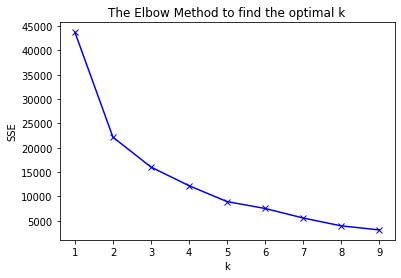

In [38]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(train[['bathroomcnt', 'bedroomcnt']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

#### Based on the Elbow Method, we chose 5 as the optimal number of clusters.

In [39]:
def target_cluster(train):
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(train[['bathroomcnt', 'bedroomcnt']])
    train['cluster'] = kmeans.predict(train[['bathroomcnt', 'bedroomcnt']])
    return train

In [40]:
train1 = target_cluster(train)

In [41]:
train1.groupby(train1['cluster']).mean().sort_values('logerror')

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1.198778e+07,1.480458e+06,1.000000,1.809395,-1.000962,6037.0,3.402942e+07,-1.182393e+08,-0.685597,1.0,1943.945696,-0.172438,-0.411156,-0.209445,-0.010761,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.190605,0.809395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.181265e+07,1.495221e+06,2.252761,1.958282,-0.448234,6037.0,3.406836e+07,-1.183058e+08,0.044094,1.0,1972.180613,0.725893,0.050911,0.045721,-0.002044,0.000000,0.747485,0.252270,0.000245,0.000000,0.000000,0.000000,0.041718,0.958282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,1.193156e+07,1.513578e+06,1.801723,3.219019,-0.239348,6037.0,3.411495e+07,-1.182121e+08,-0.354475,1.0,1956.373176,-0.305725,-0.252023,-0.160279,-0.001599,0.198277,0.801723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.782211,0.216558,0.001230,0.000000,0.000000,0.000000,0.000000
4,1.188371e+07,1.531483e+06,3.083250,2.996683,0.529216,6037.0,3.413780e+07,-1.182771e+08,0.604267,1.0,1978.965174,0.292799,0.411754,0.249676,0.001256,0.000000,0.000000,0.920730,0.075622,0.003317,0.000332,0.000000,0.000000,0.003317,0.996683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.183373e+07,1.488473e+06,3.303397,4.355282,1.438021,6037.0,3.417979e+07,-1.182861e+08,0.979117,1.0,1975.786622,-0.023304,0.564802,0.269614,0.010542,0.000000,0.033549,0.708273,0.188998,0.060638,0.007502,0.001042,0.000000,0.000000,0.000000,0.697020,0.259429,0.036258,0.006043,0.001042,0.000208


#### Number of observations per cluster

In [42]:
train1.cluster.value_counts()

0    11378
1     4799
3     4075
2     3683
4     3015
Name: cluster, dtype: int64

In [43]:
train1.groupby('cluster').mean()

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.193156e+07,1.513578e+06,1.801723,3.219019,-0.239348,6037.0,3.411495e+07,-1.182121e+08,-0.354475,1.0,1956.373176,-0.305725,-0.252023,-0.160279,-0.001599,0.198277,0.801723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.782211,0.216558,0.001230,0.000000,0.000000,0.000000,0.000000
1,1.183373e+07,1.488473e+06,3.303397,4.355282,1.438021,6037.0,3.417979e+07,-1.182861e+08,0.979117,1.0,1975.786622,-0.023304,0.564802,0.269614,0.010542,0.000000,0.033549,0.708273,0.188998,0.060638,0.007502,0.001042,0.000000,0.000000,0.000000,0.697020,0.259429,0.036258,0.006043,0.001042,0.000208
2,1.198778e+07,1.480458e+06,1.000000,1.809395,-1.000962,6037.0,3.402942e+07,-1.182393e+08,-0.685597,1.0,1943.945696,-0.172438,-0.411156,-0.209445,-0.010761,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.190605,0.809395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.181265e+07,1.495221e+06,2.252761,1.958282,-0.448234,6037.0,3.406836e+07,-1.183058e+08,0.044094,1.0,1972.180613,0.725893,0.050911,0.045721,-0.002044,0.000000,0.747485,0.252270,0.000245,0.000000,0.000000,0.000000,0.041718,0.958282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.188371e+07,1.531483e+06,3.083250,2.996683,0.529216,6037.0,3.413780e+07,-1.182771e+08,0.604267,1.0,1978.965174,0.292799,0.411754,0.249676,0.001256,0.000000,0.000000,0.920730,0.075622,0.003317,0.000332,0.000000,0.000000,0.003317,0.996683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Check validity of the clusters and X and Y variables by mapping the clusters against themselves. This pattern appears as expected. 

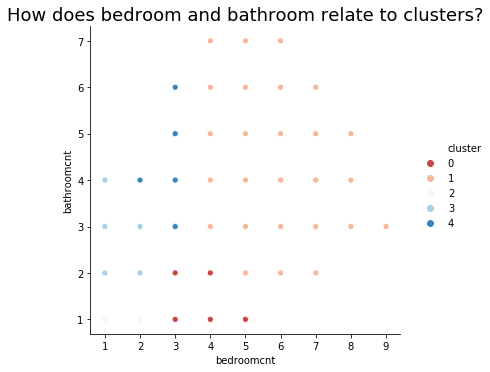

In [44]:
sns.relplot(data=train1, x='bedroomcnt', y='bathroomcnt', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does bedroom and bathroom relate to clusters?', fontsize = 18)
plt.show()

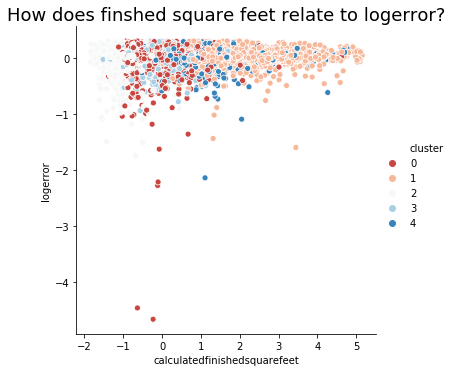

In [45]:
sns.relplot(data=train1, x='calculatedfinishedsquarefeet', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does finshed square feet relate to logerror?', fontsize = 18)
plt.show()

#### Using bedroom and bathroom counts as clusters, the graph above may indicate significant groups when looking at the finished square feet and logerror.

#### We can test the if the means are different using a one-way ANOVA test. First, we must determine if the the clusters are normally distributed. 

#### Create clusters to test for normality.

In [46]:
cluster_0 =train1[train1.cluster == 0]
cluster_1 =train1[train1.cluster == 1]
cluster_2 =train1[train1.cluster == 2]
cluster_3 =train1[train1.cluster == 3]
#cluster_4 =train1[train1.cluster == 4] Cluster 4 will not work. Unsure of error. 

#### Plot clusters using histograms to visually check if distributions are normal.  All seem to follow a Gaussian distribution. 

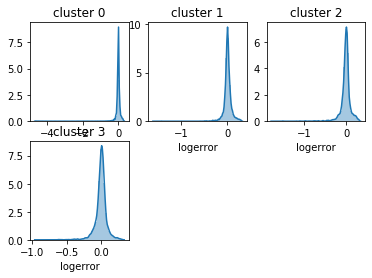

In [47]:
plt.title('Check for normality for 5 logerror clusters')

plt.subplot(231)
sns.distplot(cluster_0.logerror)
plt.title('cluster 0')

plt.subplot(232)
sns.distplot(cluster_1.logerror)
plt.title('cluster 1')

plt.subplot(233)
sns.distplot(cluster_2.logerror)
plt.title('cluster 2')

plt.subplot(234)
sns.distplot(cluster_3.logerror)
plt.title('cluster 3')

# plt.subplot(235)  Cluster 4 will not work. Unsure of error. 
# sns.distplot(cluster_4.logerror)
# plt.title('cluster 4')

plt.show()

#### Plot clusters using a Q-Q plot to visually check if distributions are normal. All clusters have questionable Gaussian distribution.

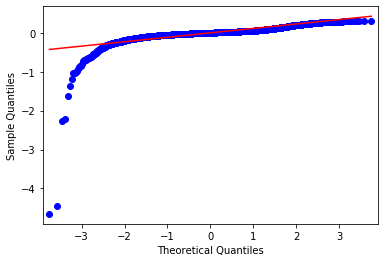

In [48]:
qqplot(cluster_0.logerror, line='s')
plt.show()

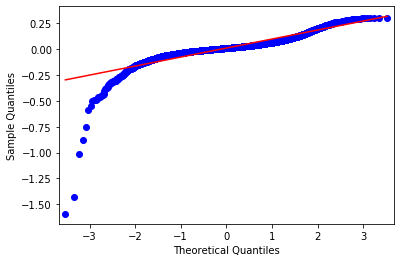

In [49]:
qqplot(cluster_1.logerror, line='s')
plt.show()

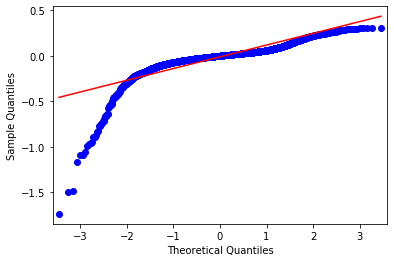

In [50]:
qqplot(cluster_2.logerror, line='s')
plt.show()

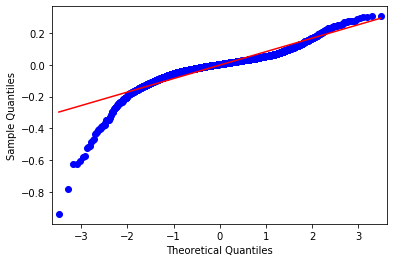

In [51]:
qqplot(cluster_3.logerror, line='s')
plt.show()

#### Run 2 parametric tests (Anderson-Darling and Shapiro-Wilks) to check if distributions are normal.

 
None of the clusters appear to be normally distributed. (Only tests for cluster_0 are shown below.)

Conclusion: normality cannot be assumed using parametric tests. The one-way ANOVA test cannot be run to test the means of the clusters against each other. 

In [52]:
#Anderson-Darling
result = anderson(cluster_0.logerror)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))


Statistic: 753.134
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [53]:
# Shapiro-Wilks
stat, p = shapiro(cluster_0.logerror)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian')
else:
	print('Sample does not look Gaussian')

Statistics=0.572, p=0.000
Sample does not look Gaussian


#### Using bedroom and bathroom counts as clusters, none of the X and Y pairings below demonstrated any visually significant relationships. 

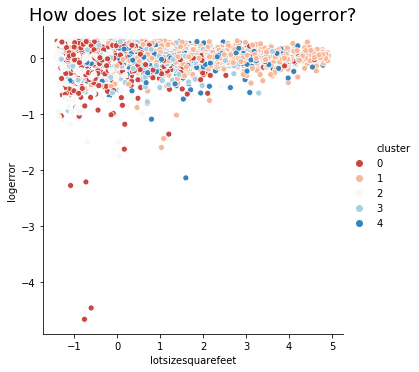

In [54]:
sns.relplot(data=train1, x='lotsizesquarefeet', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does lot size relate to logerror?', fontsize = 18)
plt.show()

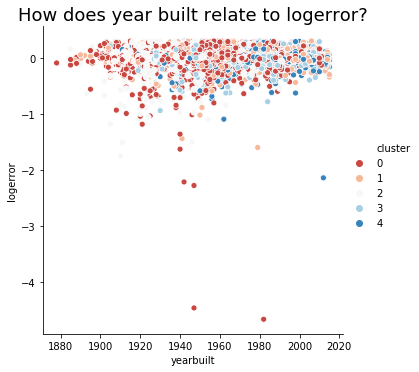

In [55]:
sns.relplot(data=train1, x='yearbuilt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does year built relate to logerror?', fontsize = 18)
plt.show()

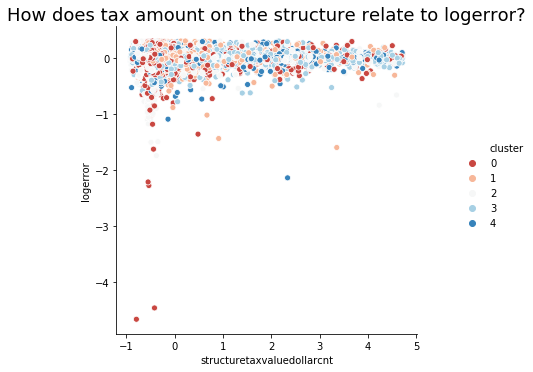

In [56]:
sns.relplot(data=train1, x='structuretaxvaluedollarcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does tax amount on the structure relate to logerror?', fontsize = 18)
plt.show()

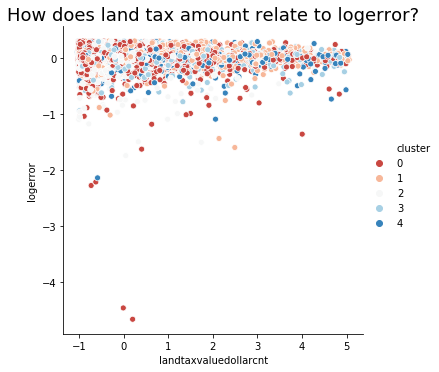

In [57]:
sns.relplot(data=train1, x='landtaxvaluedollarcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does land tax amount relate to logerror?', fontsize = 18)
plt.show()

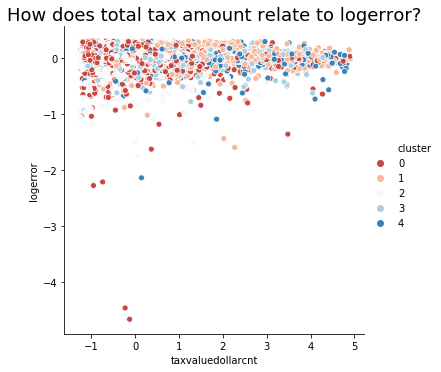

In [58]:
sns.relplot(data=train, x='taxvaluedollarcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does total tax amount relate to logerror?', fontsize = 18)
plt.show()

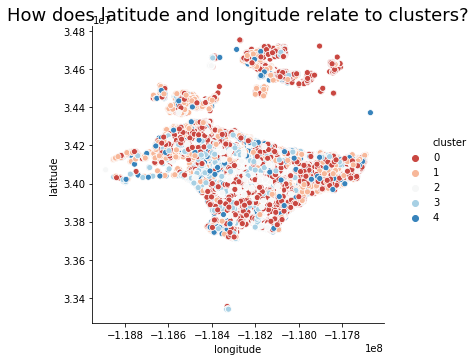

In [59]:
sns.relplot(data=train1, x='longitude', y='latitude', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does latitude and longitude relate to clusters?', fontsize = 18)
plt.show()

### Create second set of clusters: latitude and longitude

No apparent patterns were seen in the clusters

   k           sse
0  1  2.638030e+15
1  2  1.532507e+15
2  3  9.538659e+14
3  4  5.942574e+14
4  5  4.363503e+14
5  6  3.547538e+14
6  7  2.867998e+14
7  8  2.413186e+14
8  9  2.093329e+14


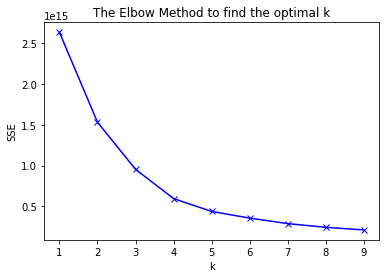

In [60]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(train[['latitude', 'longitude']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

#### Based on the Elbow Method, we chose 4 as the optimal number of clusters.

In [61]:
def target_cluster(train):
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(train[['latitude', 'longitude']])
    train['cluster'] = kmeans.predict(train[['latitude', 'longitude']])
    return train

In [62]:
train2 = target_cluster(train)

In [63]:
train2.groupby(train2['cluster']).mean().sort_values('logerror')

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.222655e+07,1.504708e+06,1.916003,2.821385,-0.256936,6037.0,3.389410e+07,-1.182546e+08,-0.217499,1.0,1955.623099,-0.146160,-0.085304,-0.006957,-0.004247,0.347816,0.429520,0.186700,0.031137,0.004586,0.000121,0.000121,0.044292,0.324523,0.437244,0.159667,0.029085,0.004345,0.000603,0.000241,0.000000
1,1.132419e+07,1.508189e+06,2.367110,3.462860,0.293553,6037.0,3.462946e+07,-1.181250e+08,-0.100432,1.0,1986.195792,-0.066187,-0.675232,-0.841315,-0.002267,0.068699,0.536711,0.357664,0.032632,0.004294,0.000000,0.000000,0.003864,0.049377,0.519536,0.349506,0.063976,0.012452,0.001288,0.000000,0.000000
2,1.124169e+07,1.494249e+06,2.370969,3.007569,0.199832,6037.0,3.420008e+07,-1.184615e+08,0.299304,1.0,1965.605702,0.144618,0.293483,0.241684,-0.000299,0.146293,0.447900,0.321721,0.060550,0.020010,0.003214,0.000311,0.040228,0.278072,0.395956,0.215759,0.061379,0.007258,0.001037,0.000207,0.000104
3,1.263902e+07,1.514954e+06,2.130792,3.102392,-0.033160,6037.0,3.406799e+07,-1.179847e+08,-0.105924,1.0,1960.504036,-0.061924,-0.115639,-0.101053,0.004719,0.222123,0.478326,0.257100,0.032586,0.008969,0.000747,0.000149,0.016143,0.210762,0.486248,0.237818,0.041405,0.005830,0.001644,0.000149,0.000000


#### Number of observations per cluster

In [64]:
train2.cluster.value_counts()

2    9645
0    8286
3    6690
1    2329
Name: cluster, dtype: int64

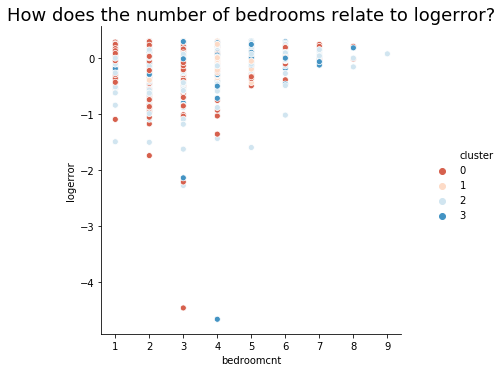

In [65]:
sns.relplot(data=train2, x='bedroomcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))
plt.title('How does the number of bedrooms relate to logerror?', fontsize = 18)
plt.show()

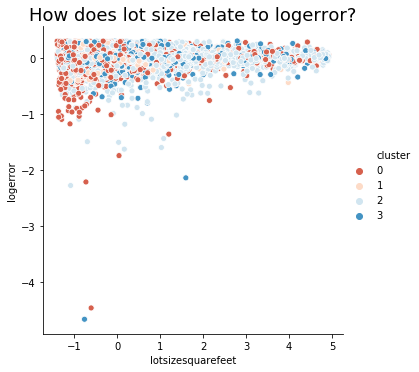

In [66]:
sns.relplot(data=train2, x='lotsizesquarefeet', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))
plt.title('How does lot size relate to logerror?', fontsize = 18)
plt.show()

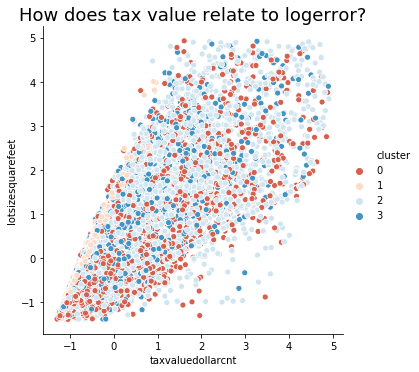

In [67]:
sns.relplot(data=train2, x='taxvaluedollarcnt', y='lotsizesquarefeet', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))

plt.title('How does tax value relate to logerror?', fontsize = 18)
plt.show()

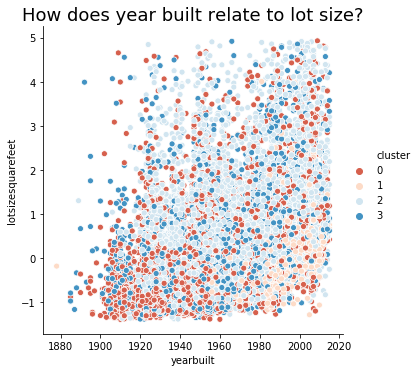

In [68]:
sns.relplot(data=train2, x='yearbuilt', y='lotsizesquarefeet', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))

plt.title('How does year built relate to lot size?', fontsize = 18)
plt.show()

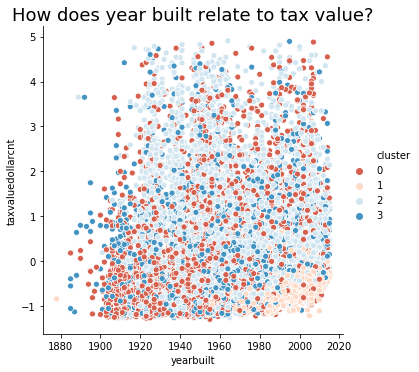

In [69]:
sns.relplot(data=train2, x='yearbuilt', y='taxvaluedollarcnt', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))

plt.title('How does year built relate to tax value?', fontsize = 18)
plt.show()

### Histograms of all variables

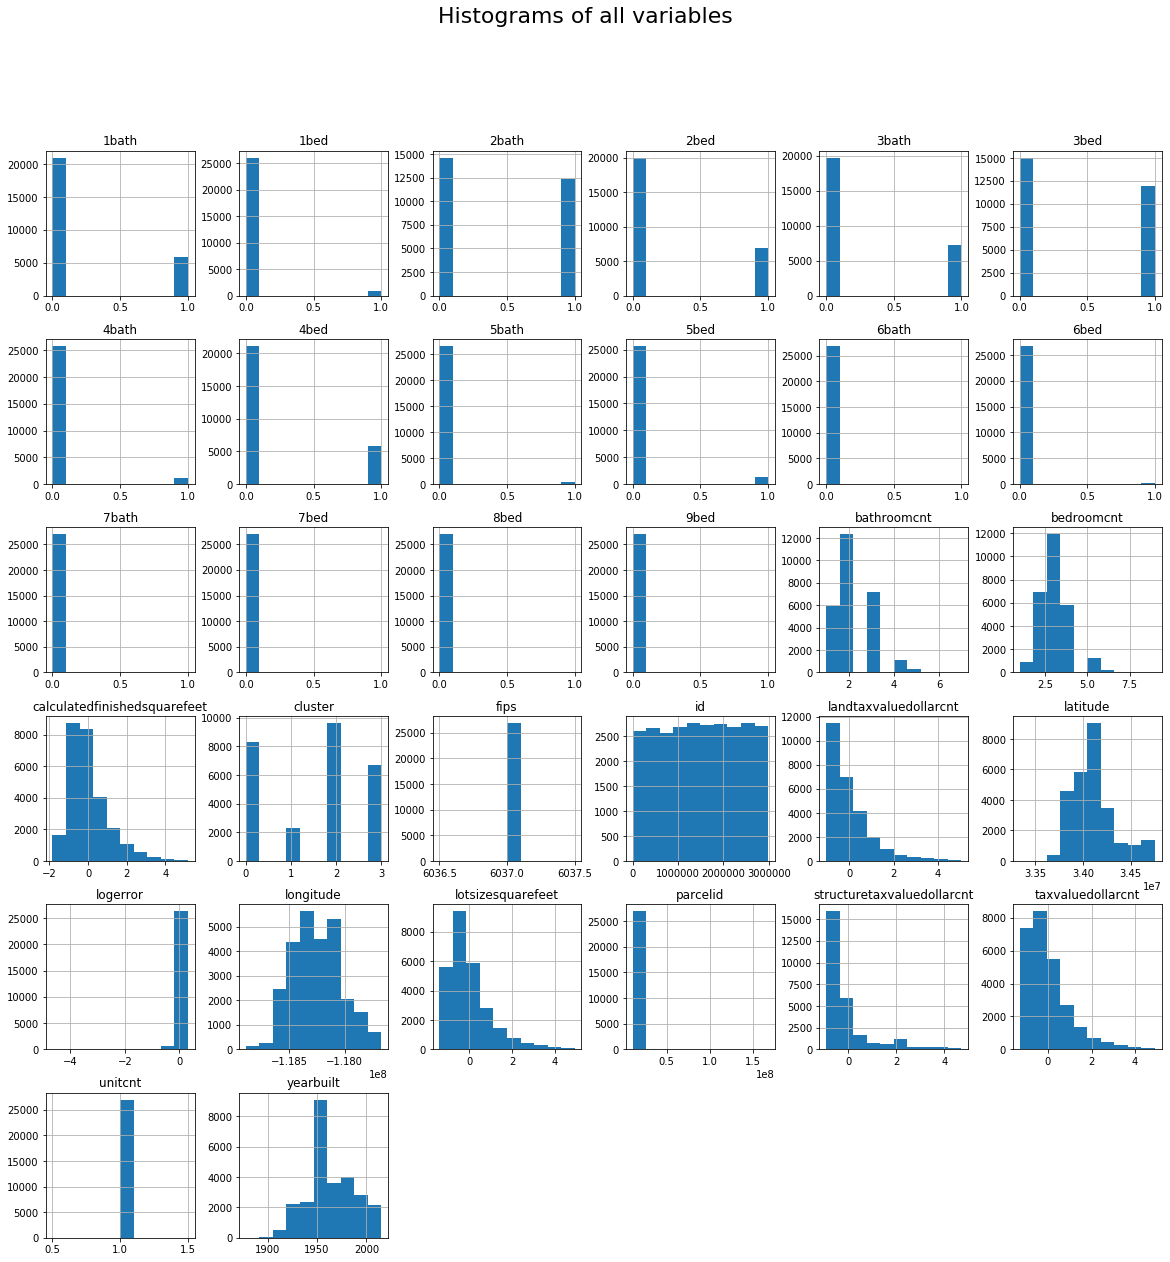

In [70]:
train.hist(figsize=(20, 20), bins=10, log=False)
plt.suptitle('Histograms of all variables', fontsize = 22)
plt.show()

### Jointplots (scatter plot and histograms) of select variables do not show any obvous relationships.

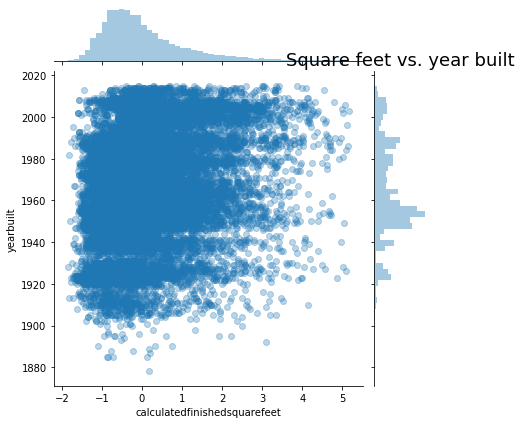

In [71]:
sns.jointplot(data=train, x='calculatedfinishedsquarefeet', y='yearbuilt', alpha = .3)
plt.title('Square feet vs. year built', fontsize = 18)
plt.show()

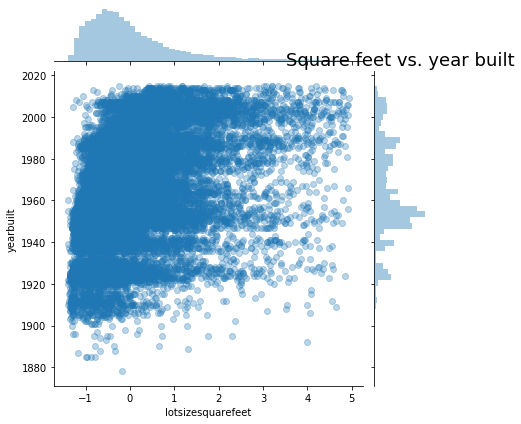

In [72]:
sns.jointplot(data=train, x='lotsizesquarefeet', y='yearbuilt', alpha = .3)
plt.title('Square feet vs. year built', fontsize = 18)
plt.show()

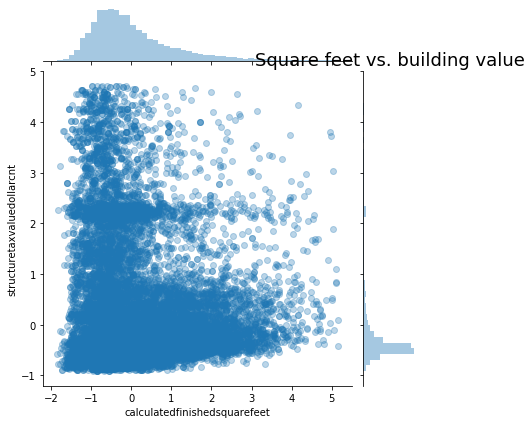

In [73]:
sns.jointplot(data=train, x='calculatedfinishedsquarefeet', y='structuretaxvaluedollarcnt', alpha = .3)
plt.title('Square feet vs. building value', fontsize = 18)
plt.show()

## Correlation matrix/heatmap of all variables

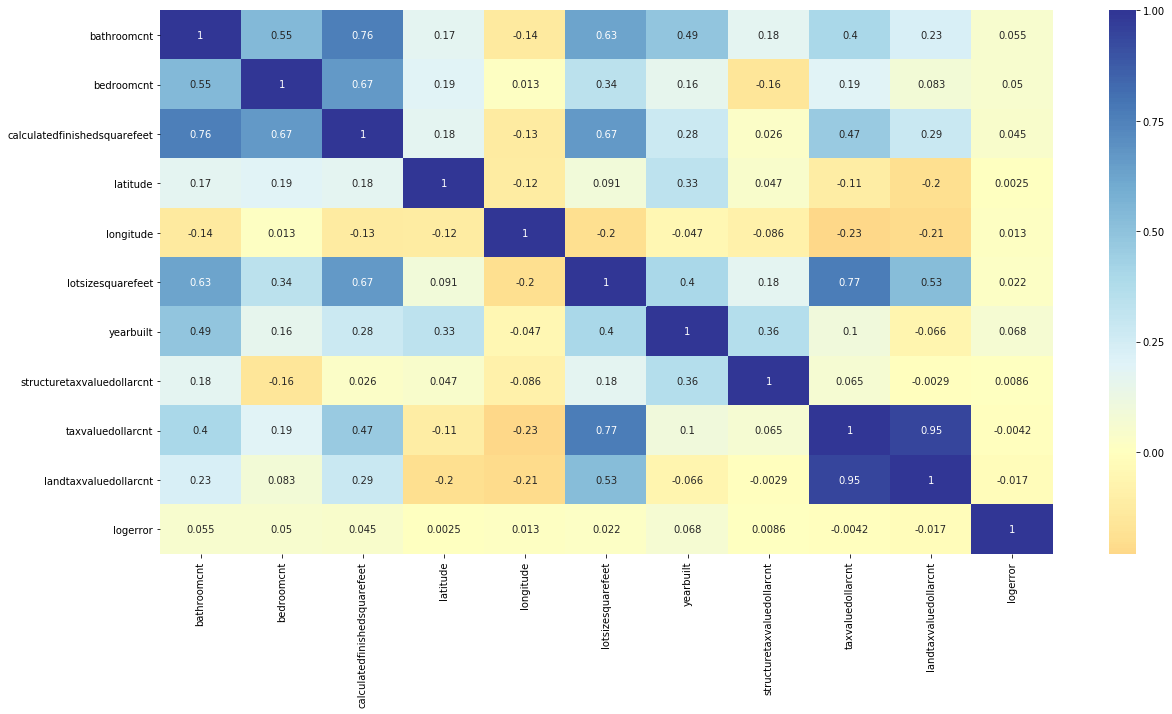

In [74]:
corr1 = train[['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet','latitude', 'longitude', 'lotsizesquarefeet','yearbuilt',\
               'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'logerror']]
plt.figure(figsize=(20,10))
sns.heatmap(corr1.corr(), cmap='RdYlBu', annot=True, center=0)
plt.show()

### T-tests

#### T-test 1

H<sub>0</sub> : The logerror for single-unit properties with 1 bathroom is the same as properties with 2 bathrooms

H<sub>a</sub> : The logerror for single-unit properties with 1 bathroom is NOT the same as properties with 2 bathrooms

In [75]:
one_bathroom = train[train['bathroomcnt']==1.0]
three_bathroom = train[train['bathroomcnt']==2.0]
stats.ttest_ind(one_bathroom['logerror'], three_bathroom['logerror'])

Ttest_indResult(statistic=-5.039038427519528, pvalue=4.7234278177180693e-07)

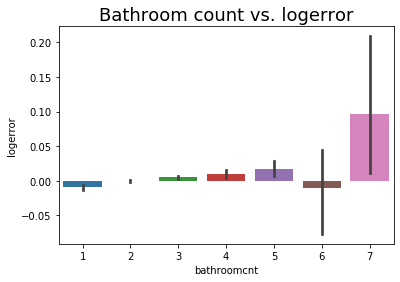

In [76]:
plt.title('Bathroom count vs. logerror', fontsize = 18)
sns.barplot(x=train["bathroomcnt"], y=train["logerror"])
plt.show()

#### Reject H<sub>0</sub>. The logerror for single-unit properties with 1 bathroom is NOT the same as properties with 2 bathrooms.

More generalized, the logerror is statistically different for all bathroom counts except 6.

#### T-test 2

H<sub>0</sub> : The logerror for single-unit properties with 1 bedroom is the same as properties with 3 bedrooms

H<sub>a</sub> : The logerror for single-unit properties with 1 bedroom is NOT the same as properties with 3 bedrooms

In [77]:
one_bedroom = train[train['bedroomcnt']==1.0]
three_bedroom = train[train['bedroomcnt']==5.0]
stats.ttest_ind(one_bedroom['logerror'], three_bedroom['logerror'])

Ttest_indResult(statistic=-3.9223366722762774, pvalue=9.04721047973656e-05)

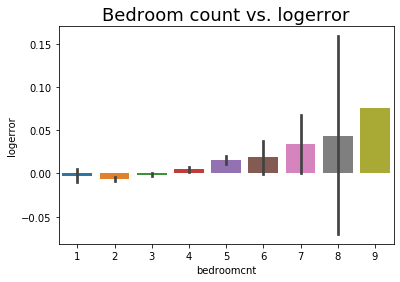

In [78]:
plt.title('Bedroom count vs. logerror', fontsize = 18)
sns.barplot(x=train["bedroomcnt"], y=train["logerror"])
plt.show()

#### Fail to reject H<sub>0</sub>.  The logerror for single-unit properties with 1 bedroom is the same as properties with 2 bedrooms.

More generalized, the logerror is statistically different for for all single-unit residences with 5 or more bedrooms.

### Create dependent (y) variable: logerror

In [79]:
X_train = train.drop(columns ='logerror')
y_train = train[['logerror']]
X_test = test.drop(columns ='logerror')
y_test = test[['logerror']]

### Drop redundant columns

In [80]:
train.drop(columns = (['bathroomcnt', 'bedroomcnt']))
test.drop(columns = (['bathroomcnt', 'bedroomcnt']))

,index,parcelid,id,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
0,1751,12280930,2050136,832,6037,33917077,-118212065,5219,1,1941,78063,240200,162137,0.002405,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4689,13088760,1009542,2224,6037,34013957,-117880711,9163,1,1976,122701,146366,23665,0.176784,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,46673,13049978,1874533,1754,6037,34133940,-117748174,9416,1,1988,212410,394701,182291,-0.012560,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10416,12719110,2922212,1400,6037,33941307,-118067447,40505,1,2010,111471,360389,248918,-0.007680,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,42031,13045149,2142874,1796,6037,34121583,-117806596,6264,1,1988,193872,323227,129355,0.036244,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,38846,10809985,2312946,2082,6037,34154969,-118600611,9940,1,1964,95162,135748,40586,0.049716,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,35129,11752453,2242008,2969,6037,34056812,-118354931,10803,1,1926,270460,1352304,1081844,-0.054156,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,31904,12402221,1125858,1488,6037,33881820,-118042723,4756,1,1968,143816,377554,233738,-0.036531,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,11408,12655780,1664155,1343,6037,33715400,-118291000,14287,1,1990,225849,445278,219429,-0.020473,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9694,11769197,1928976,1242,6037,34005987,-118252130,5102,1,1951,99667,194519,94852,-0.092878,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Create baseline model

In [81]:
predictions=pd.DataFrame({'actual':y_train['logerror']}).reset_index(drop=True)
predictions['baseline'] = y_train.mean()[0]
predictions.head()

,actual,baseline
0,-0.061629,-0.000437
1,0.015970,-0.000437
2,-0.133100,-0.000437
3,-0.043454,-0.000437
4,0.016932,-0.000437


## Clustering From The Prepped DataFrame new_df

## Split It

In [82]:
train, test = train_test_split(new_df, test_size=.30, random_state = 123)
train.columns

Index(['parcelid', 'id', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude',
       'lotsizesquarefeet', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'logerror'],
      dtype='object')

# Scale It

## Uniform for columns where distance isn't too much of a concern
## MinMax for when distance is important

In [83]:
def scale_uniform(train, test, column_list):
    scaler = QuantileTransformer(output_distribution='uniform', random_state=123)
    train_scaled = pd.DataFrame(scaler.fit_transform(train[column_list]), 
                                columns = column_list, 
                                index = train.index)
    train.drop(columns=column_list, inplace=True)
    train = train.join(train_scaled)
    
    test_scaled = pd.DataFrame(scaler.transform(test[column_list]), 
                                columns = column_list, 
                                index = test.index)
    test.drop(columns=column_list, inplace=True)
    test = test.join(test_scaled)
    
    return train, test, scaler

def scale_minmax(train, test, column_list):
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = pd.DataFrame(scaler.fit_transform(train[column_list]), 
                                columns = column_list, 
                                index = train.index)
    train.drop(columns=column_list, inplace=True)
    train = train.join(train_scaled)
    
    test_scaled = pd.DataFrame(scaler.transform(test[column_list]), 
                                columns = column_list, 
                                index = test.index)
    test.drop(columns=column_list, inplace=True)
    test = test.join(test_scaled)
    
    return train, test, scaler

column_list1 = ['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt',]
train, test, scaler_uniform = scale_uniform(train, test, column_list1)

column_list2 = ['latitude','longitude','yearbuilt']
train, test, scaler_minmax = scale_minmax(train, test, column_list2)

# Cluster Something
K-Means
Elbow Method to determine best 'K'
Cluster latitude and longitude along with structuretaxvaluedollarcnt.

In [84]:
# Put your columns into a list....
cluster1_cols = ['latitude','longitude','structuretaxvaluedollarcnt']

In [85]:
def select_k(cluster_df, ks):
    sse = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, n_init=1, max_iter=100, random_state=123)
        kmeans.fit(cluster_df)

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_)

    # print(pd.DataFrame(dict(k=ks, sse=sse)))

    p = plt.plot(ks, sse, 'bx-')
    p = plt.xlabel('k')
    p = plt.ylabel('SSE')
    p = plt.title('The Elbow Method to find the optimal k')

    compare_df = pd.DataFrame(dict(k=ks, sse=sse)).assign(change_in_sse=lambda df: df.sse.diff())
    return compare_df, p

(   k          sse  change_in_sse
 0  1  3789.942096            NaN
 1  2  2060.068295   -1729.873802
 2  3  1677.088564    -382.979731
 3  4  1384.891896    -292.196668
 4  5  1140.076377    -244.815518
 5  6   989.946658    -150.129719
 6  7   884.718121    -105.228537
 7  8   800.500659     -84.217463
 8  9   718.105779     -82.394879,
 Text(0.5, 1.0, 'The Elbow Method to find the optimal k'))

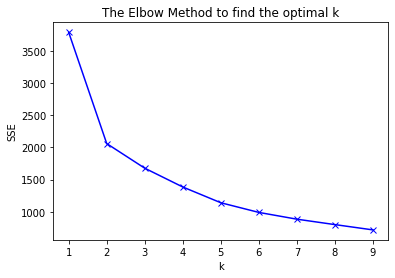

In [86]:
# Look at the SSE for each K to see where the best cutoff lies....
select_k(cluster_df = train[cluster1_cols], ks = range(1,10))

In [87]:
# Looking at the difference between to cluster groups...

def compare_clusters(cluster_df, x_column, y_column, z_column, k1, k2):
    estimators = [(str(k1)+' Clusters', KMeans(n_clusters=k1, n_init=1, max_iter=100, random_state=123)),
                  (str(k2)+' Clusters', KMeans(n_clusters=k2, n_init=1, max_iter=100, random_state=123))]
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})
    
    for ax, (title, kmeans) in zip(axs, estimators):
        # fit the kmeans object
        kmeans.fit(cluster_df)
        
        labels = kmeans.labels_
        
        ax.scatter(cluster_df[x_column], 
                   cluster_df[y_column],
                   cluster_df[z_column],
                   c=labels.astype(np.float), edgecolor='k')
        ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
        ax.set(xlabel=x_column, ylabel=y_column, zlabel=z_column)
        ax.set(title=title)
    
    plt.show()

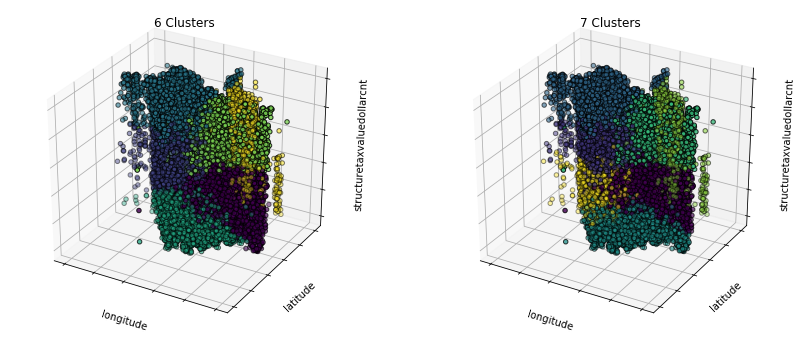

In [88]:
compare_clusters(cluster_df=train[cluster1_cols],
                x_column='longitude', y_column='latitude', z_column='structuretaxvaluedollarcnt',
                k1=6, k2=7)

__6 clusters look pretty good to me__

In [89]:
def create_k_clusters(train, test, cluster_feature_id, cluster_cols, k):
    kmeans = KMeans(n_clusters=k, n_init=1, max_iter=100, random_state=123)
    kmeans.fit(train[cluster_cols])
    cluster_feature = 'cluster'+str(cluster_feature_id)+'_id'
    train[cluster_feature] = kmeans.predict(train[cluster_cols])
    test[cluster_feature] = kmeans.predict(test[cluster_cols])
    return train, test, kmeans

In [90]:
train, test, kmeans1 = create_k_clusters(train, test, cluster_feature_id = 1, cluster_cols = cluster1_cols, k=6)

In [91]:
# Changing the name in case I want to make more clusters later...

train.rename(index=str, columns={'cluster1_id': 'cluster_loc'}, inplace=True)
test.rename(index=str, columns={'cluster1_id': 'cluster_loc'}, inplace=True)

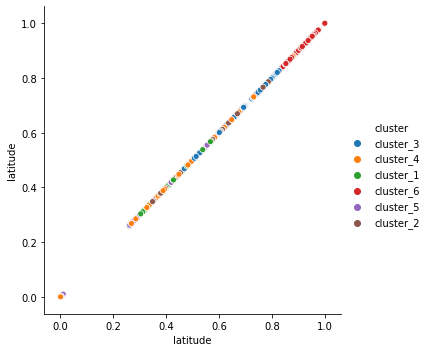

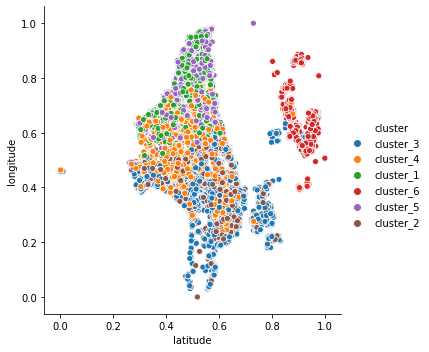

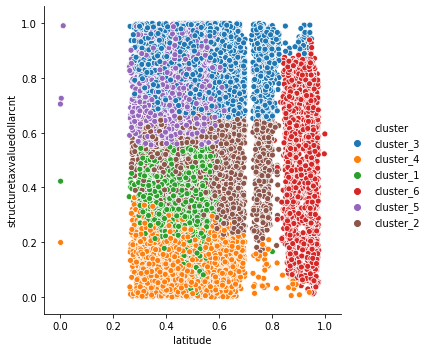

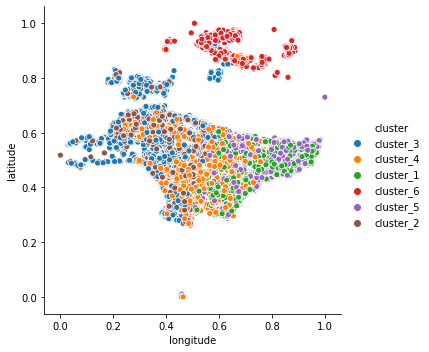

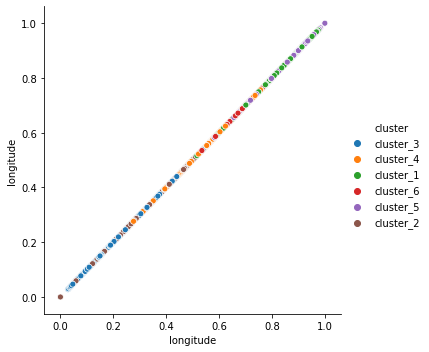

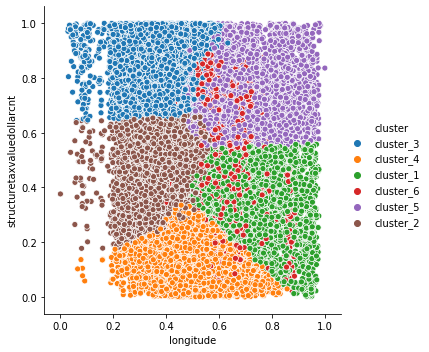

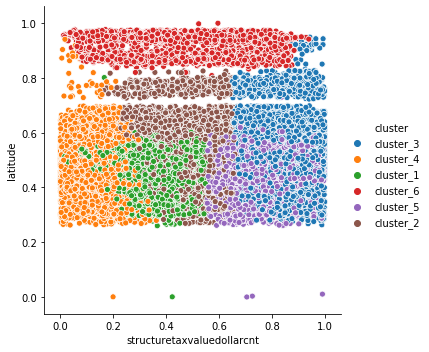

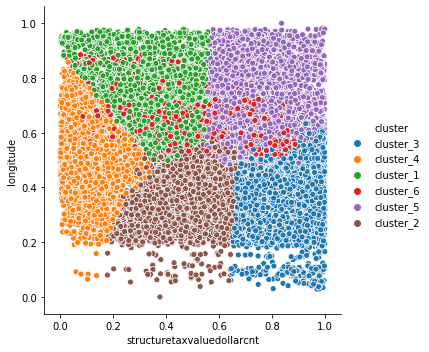

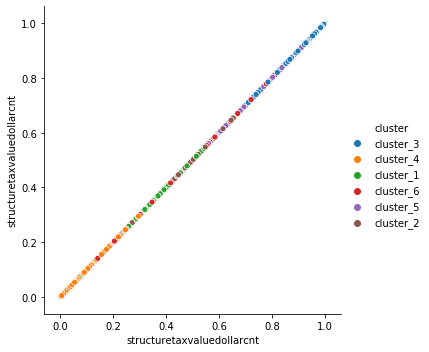

In [92]:
# Creating a column to store the kmean labels, also graphs

train['cluster'] = kmeans1.labels_
train.cluster = 'cluster_' + (train.cluster + 1).astype('str')
for i in range(0,len(cluster1_cols)):
    for j in range(0, len(cluster1_cols)):
        sns.relplot(data=train, x=cluster1_cols[i], y=cluster1_cols[j], hue='cluster')

In [93]:
# Looking at the mean log errors for each cluster group

pd.DataFrame(train.groupby(['cluster_loc'])['logerror'].mean().reset_index())


,cluster_loc,logerror
0,0,0.003975
1,1,0.000268
2,2,-0.000530
3,3,-0.007378
4,4,0.005911
5,5,-0.002585


## Looking for the weak clusters through p values

In [94]:
less_significant_clusters = []

for i in range(0,len((train.cluster_loc)+1)):
    stat, pval = stats.ttest_ind(
        train[train.cluster_loc == i].logerror.dropna(),
        train[train.cluster_loc != i].logerror.dropna())
    if pval > .05:
        less_significant_clusters = less_significant_clusters + [i]

In [95]:
less_significant_clusters

[1, 2, 5]

In [96]:
# If a row is located in one of those clusters above, it's replaced with a -1 instead of it's previous cluster loc.

train.cluster_loc = train.cluster_loc.replace(less_significant_clusters, -1)
test.cluster_loc = test.cluster_loc.replace(less_significant_clusters, -1)

In [97]:
# Segregating by cluster columns or not

cols_to_remove = ['parcelid','unitcnt', 'id']
non_cluster_features = ['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'parcelid', 'id',
                        'taxvaluedollarcnt','bathroomcnt', 'bedroomcnt', 'yearbuilt', 'latitude', 'longitude']
train_no_clusters = train[non_cluster_features+['fips','logerror']]
test_no_clusters = test[non_cluster_features+['fips','logerror']]

In [98]:
cols_to_remove = cols_to_remove + non_cluster_features
train_clusters = train.drop(columns=cols_to_remove +['cluster'])
test_clusters = test.drop(columns=cols_to_remove)



# Let's encode!

In [99]:
def encode(train, test, col_name):
  
    encoded_values = sorted(list(train[col_name].unique()))
    columns = [col_name + '_' + str(val) for val in encoded_values]

    # Integer Encoding
    int_encoder = LabelEncoder()
    train.encoded = int_encoder.fit_transform(train[col_name])
    test.encoded = int_encoder.transform(test[col_name])

    # create 2D np arrays of the encoded variable (in train and test)
    train_array = np.array(train.encoded).reshape(len(train.encoded),1)
    test_array = np.array(test.encoded).reshape(len(test.encoded),1)
    
    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=columns, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                               columns=columns, index=test.index)
    test = test.join(test_encoded)

    return train, test, int_encoder, ohe

def one_hot_encode(train, test, col_name):
  
    encoded_values = sorted(list(train[col_name].unique()))
    columns = [col_name + '_' + str(val) for val in encoded_values]

    # create 2D np arrays of the encoded variable (in train and test)
    train_array = np.array(train[col_name]).reshape(len(train[col_name]),1)
    test_array = np.array(test[col_name]).reshape(len(test[col_name]),1)
    
    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=columns, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                               columns=columns, index=test.index)
    test = test.join(test_encoded)

    return train, test, ohe

In [100]:
train_clusters, test_clusters, ohe_loc = one_hot_encode(train_clusters, test_clusters, 'cluster_loc')

In [101]:
cols_to_drop = ['cluster_loc', 'cluster_loc_-1', 'logerror']
X_train = train_clusters.drop(columns=cols_to_drop)
X_test = test_clusters.drop(columns=cols_to_drop)

In [102]:
cols_to_drop = ['logerror', 'fips']

X_train_nc = train_no_clusters.drop(columns=cols_to_drop)
X_test_nc = test_no_clusters.drop(columns=cols_to_drop)

In [103]:
y_train = train[['logerror']]
y_test = test[['logerror']]

## Model

In [104]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor, LassoCV
from sklearn.tree import DecisionTreeRegressor

In [105]:
SE = y_train.logerror * y_train.logerror
MSE = SE.mean()
RMSE = MSE**1/2
RMSE

0.005590386846558322

## The baseline RMSE for mean logerror is kinda small!

## Clusters

__Lasso Cross Validation__

In [106]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_train)
mean_squared_error(y_train, y_pred)**1/2

0.005590386846558315

The smallest of changes!

__Decision Tree__

In [107]:
dt = DecisionTreeRegressor(max_depth= 5, random_state=123)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_train)
mean_squared_error(y_train, y_pred)**1/2

0.005096905735809681

A more significant change, relatively speaking

## Takeaway : Decision Tree method is much better at creating a better model than Lasso Cross Validation

## Non Clusters

__Lasso Cross Validation__

In [108]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_nc, y_train)
y_pred = lasso.predict(X_train_nc)
mean_squared_error(y_train, y_pred)**1/2

0.005590386846558315

__A barely noticeable change__

__Decision Tree__

In [109]:
dt = DecisionTreeRegressor(max_depth = 5, random_state=123)
dt.fit(X_train_nc, y_train)
y_pred = dt.predict(X_train_nc)
mean_squared_error(y_train, y_pred)**1/2

0.005216157890389604

## Takeaway: The decision tree is the best model used, and non cluster features performed better than the cluster.

## Conclusions:

Further cluster exploration and feature engineering will be required to produce a better model for the data used in the test. It is important to note that through the removal of outliers a very standardized set of data was created prior to feature engineering. The use of domain knowledge will be imperative to creating clusters that pair better than the features used in this study. 

In [110]:
lm1=LinearRegression()
lm1.fit(X_train[['bathroomcnt', 'bedroomcnt']],y_train)
lm1_predictions=lm1.predict(X_train[['bathroomcnt', 'bedroomcnt']])
predictions['lm1']=lm1_predictions

KeyError: "None of [Index(['bathroomcnt', 'bedroomcnt'], dtype='object')] are in the [columns]"

In [ ]:
MSE_baseline = mean_squared_error(predictions.actual, predictions.baseline)
SSE_baseline = MSE_baseline*len(predictions.actual)
RMSE_baseline = sqrt(MSE_baseline)
r2_baseline = r2_score(predictions.actual, predictions.baseline)
print("MSE =",MSE_baseline, "SSE =", SSE_baseline, "RMSE =", RMSE_baseline, "R2 =", r2_baseline)

### Create linear regression model prior to feature engineering

In [ ]:
MSE_1 = mean_squared_error(predictions.actual, predictions.lm1)
SSE_1 = MSE_1*len(predictions.actual)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(predictions.actual, predictions.lm1)
print("MSE =", MSE_1, "SSE=", SSE_1, "RMSE=", RMSE_1, "R2=", r2_1)

In [ ]:
model=lm1.predict(X_test[['bathroomcnt', 'bedroomcnt']])
model=model.ravel().reshape(11550)
y_test1=np.array(y_test).ravel().reshape(11550)
best_model=pd.DataFrame({'predictions':model,'logerror':y_test1})
best_model.head()

In [ ]:
pd.DataFrame({'actual': predictions.actual,
              'lm1': predictions.lm1,
              'lm_baseline': predictions.baseline.ravel()})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')
min = -.5
max = .5
plt.plot([min, max],[min, max], c='red', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Log Error')
plt.show()

### Conclusion

## Feature engineering and revised regression model: Look at that difference!

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from sklearn.linear_model import LassoCV, LinearRegression

def optimal_features(X_train, X_test, y_train, number_of_features):
    '''Taking the output of optimal_number_of_features, as n, and use that value to 
    run recursive feature elimination to find the n best features'''
    cols = list(X_train.columns)
    model = LinearRegression()
    
    #Initializing RFE model
    rfe = RFE(model, number_of_features)

    #Transforming data using RFE
    train_rfe = rfe.fit_transform(X_train,y_train)
    test_rfe = rfe.transform(X_test)
    
    #Fitting the data to model
    model.fit(train_rfe, y_train)
    temp = pd.Series(rfe.support_,index = cols)
    selected_features_rfe = temp[temp==True].index
    
    X_train_rfe = pd.DataFrame(train_rfe, columns=selected_features_rfe)
    X_test_rfe = pd.DataFrame(test_rfe, columns=selected_features_rfe)
    
    return selected_features_rfe, X_train_rfe, X_test_rfe

In [ ]:
optimal_features(X_train, X_test, y_train, 14)
X_train_rfe = optimal_features(X_train, X_test, y_train, 12)[1]
X_test_rfe = optimal_features(X_train, X_test, y_train, 12)[2]
# X_train_rfe

In [ ]:
lm2 =LinearRegression()
lm2.fit(X_train_rfe,y_train)
lm2_predictions=lm2.predict(X_train_rfe)
predictions['lm2']=lm2_predictions

lm2_y_intercept = lm2.intercept_
# print("intercept: ", lm1_y_intercept)
lm2_coefficients = lm2.coef_
# print("coefficients: ", lm1_coefficients)

In [ ]:
MSE_2 = mean_squared_error(predictions.actual, predictions.lm2)
SSE_2 = MSE_2*len(predictions.actual)
RMSE_2 = sqrt(MSE_2)
r2_2 = r2_score(predictions.actual, predictions.lm2)
print("MSE =", MSE_2, "SSE=", SSE_2, "RMSE=", RMSE_2, "R2=", r2_2)

__Conclusion: Model is sliiiiightly improved by the optimal features function. Further feature engineering is required to seek further improvement.__

### Random forest analysis

In [ ]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',min_samples_leaf=3,n_estimators=100,max_depth=2, random_state=123)

In [ ]:
dtx = X_train[['latitude', 'longitude', 'bathroomcnt', 'bedroomcnt']]
dty = train.cluster

In [ ]:
rf.fit(dtx,dty)

In [ ]:
print(rf.feature_importances_)
y_pred = pd.DataFrame(rf.predict(dtx))
y_pred_proba = rf.predict_proba(dtx)
rf.score(dtx,dty)
print(classification_report(dty,y_pred))

### Conclusion: 